# Import Libraries

In [65]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Load the preprocessed data


In [60]:
data_dir = Path("../../data/processed")  
files = {
    "DF": data_dir / "players_data_DF.parquet",
    "FW": data_dir / "players_data_FW.parquet",
    "GK": data_dir / "players_data_GK.parquet",
    "MF": data_dir / "players_data_MF.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_fw = load_clean(files["FW"])
df_df = load_clean(files["DF"])
df_gk = load_clean(files["GK"])
df_mf = load_clean(files["MF"])



# Cluster Forwards 

In [61]:
print("FW shape:", df_fw.shape)
df_fw.head()
df_fw.info()
df_fw.describe()
df_fw.select_dtypes(include="object").columns


drop_cols = ["Rk", "__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
fw_features = df_fw.drop(columns=drop_cols, errors="ignore")

# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", fw_features.shape)
fw_features.head()

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy="mean")
fw_imputed = imputer.fit_transform(fw_features)

# Standardize the features
scaler = StandardScaler()
fw_scaled = scaler.fit_transform(fw_imputed)

# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=2, random_state=42)
fw_pca = pca.fit_transform(fw_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
fw_clusters = kmeans.fit_predict(fw_pca)

# Add cluster labels to the original dataframe for easy reference
df_fw["cluster"] = fw_clusters



FW shape: (464, 127)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Columns: 127 entries, Rk to __index_level_0__
dtypes: float64(73), int64(48), object(6)
memory usage: 460.5+ KB
Numeric dataset shape: (464, 119)


### Plot and List

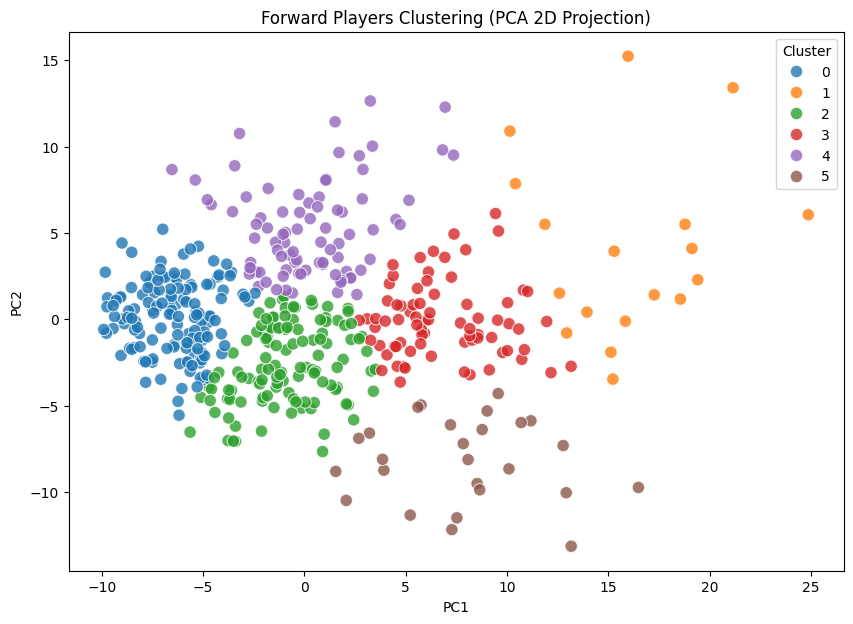

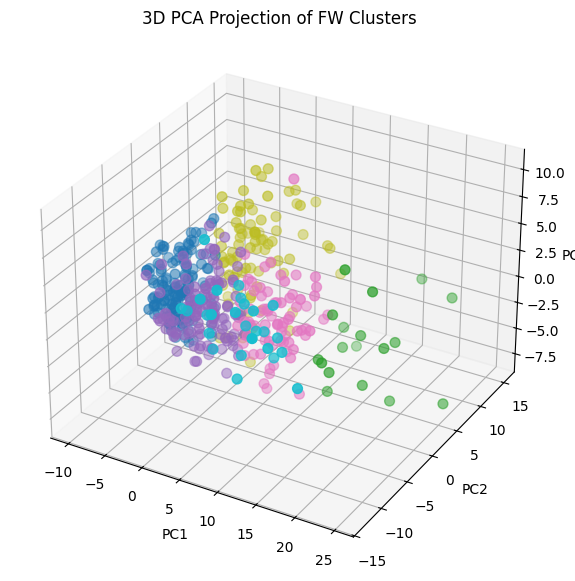

Eigenvalues (variance explained by each PC): [39.47504375 16.93405314 10.37899979]
Explained variance ratio: [0.33100814 0.14199628 0.08703051]
Cumulative variance explained: [0.33100814 0.47300442 0.56003493]


In [62]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca[:,0], 
    y=fw_pca[:,1], 
    hue=df_fw["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Forward Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Fit PCA for 3 components
pca_3d = PCA(n_components=3, random_state=42)
fw_pca_3d = pca_3d.fit_transform(fw_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    fw_pca_3d[:,0], fw_pca_3d[:,1], fw_pca_3d[:,2], 
    c=df_fw["cluster"], cmap="tab10", s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of FW Clusters")
plt.show()

# Print eigenvalues / explained variance
print("Eigenvalues (variance explained by each PC):", pca_3d.explained_variance_)
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca_3d.explained_variance_ratio_))


In [63]:
df_fw.head()

cluster_0_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
print(f"Players in cluster 0: {len(cluster_0_players)}")
cluster_0_players




Players in cluster 0: 18


,Player,Squad,Pos,cluster
11,Maghnes Akliouche,Monaco,"FW,MF",1
35,Alex Baena,Villarreal,"MF,FW",1
39,Bradley Barcola,Paris S-G,FW,1
80,Rayan Cherki,Lyon,"FW,MF",1
90,Matheus Cunha,Wolves,"MF,FW",1
103,Ousmane Dembélé,Paris S-G,FW,1
170,Mason Greenwood,Marseille,"FW,MF",1
205,Alex Iwobi,Fulham,"FW,MF",1
216,Vinicius Júnior,Real Madrid,FW,1
276,Kylian Mbappé,Real Madrid,FW,1


### Evaluate

In [70]:

sil_score = silhouette_score(fw_scaled, df_fw["cluster"])
print("Silhouette Score:", sil_score)



ch_score = calinski_harabasz_score(fw_scaled, df_fw["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=fw_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))

low_variance = fw_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.10994686537497673
Calinski-Harabasz Score: 61.66944662720015
Top PC1 drivers:
 Rec                         0.150238
Carries                     0.150227
Touches                     0.150121
Live_stats_possession       0.150047
Att 3rd_stats_possession    0.148601
SCA                         0.147415
PassLive                    0.144888
Live                        0.142394
Att                         0.141586
TotDist_stats_possession    0.139514
KP                          0.138316
Cmp                         0.135723
PrgP                        0.134049
PrgDist_stats_possession    0.133800
PPA                         0.133366
Name: PC1, dtype: float64

Top PC2 drivers:
 xG+xAG                      0.195853
npxG                        0.194847
xG                          0.192568
SoT/90                      0.192535
G+A-PK                      0.179096
Sh/90                       0.177096
SoT                         0.175185
G-PK                        0.172819
Gls  